In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Activation, BatchNormalization, MaxPooling1D
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, RepeatVector, TimeDistributed, RNN
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.layers import Attention

In [2]:

excel_path = '/content/drive/MyDrive/Thermal Runaway/SNL_NMC-LMO_Graphite_26Ah_100SOC_a.xlsx'
df = pd.read_excel(excel_path, sheet_name='Sheet1')

In [3]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.interpolate(method='linear', limit_direction='forward')

df = df.fillna(method='bfill').fillna(method='ffill')

print("\nData Types After Conversion:")
print(df.dtypes)
print("\nMissing Values After Interpolation:")
print(df.isnull().sum())


Data Types After Conversion:
Test Time [s]                     float64
Displacement [mm]                 float64
Penetrator Force [mm]             float64
vCell [V]                         float64
tAmbient [C]                      float64
TC1 near positive terminal [C]    float64
TC2 near negative terminal [C]    float64
TC3 bottom - bottom [C]           float64
TC4 bottom - top [C]              float64
TC5 above punch [C]               float64
TC6 below punch [C]               float64
dtype: object

Missing Values After Interpolation:
Test Time [s]                     0
Displacement [mm]                 0
Penetrator Force [mm]             0
vCell [V]                         0
tAmbient [C]                      0
TC1 near positive terminal [C]    0
TC2 near negative terminal [C]    0
TC3 bottom - bottom [C]           0
TC4 bottom - top [C]              0
TC5 above punch [C]               0
TC6 below punch [C]               0
dtype: int64


<ipython-input-3-e52da27c76bf>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')


In [4]:
feature_cols = ['Test Time [s]', 'Displacement [mm]', 'Penetrator Force [mm]', 'vCell [V]', 'tAmbient [C]']
target_cols = ['TC1 near positive terminal [C]', 'TC2 near negative terminal [C]',
               'TC3 bottom - bottom [C]', 'TC4 bottom - top [C]',
               'TC5 above punch [C]', 'TC6 below punch [C]']

In [5]:

for lag in (1,2,3):
    for col in feature_cols + target_cols:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)
for col in feature_cols:
    df[f'{col}_rm5'] = df[col].rolling(5).mean()
    df[f'{col}_rs5'] = df[col].rolling(5).std()
df = df.fillna(method='bfill').fillna(method='ffill')


<ipython-input-5-25564b4ec655>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')


In [6]:
for col in target_cols:
    df[f'{col}_smoothed'] = savgol_filter(
        df[col], window_length=7, polyorder=2, mode='interp'
    )

df = df.fillna(method='bfill').fillna(method='ffill')


<ipython-input-6-422a15a959c8>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')


In [7]:
features = df[feature_cols].values
targets = df[target_cols].values

In [8]:
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

target_scaler = StandardScaler()
targets_scaled = target_scaler.fit_transform(targets)

In [9]:
pca = PCA(n_components=5)
features_pca = pca.fit_transform(features_scaled)

In [10]:
def create_sequences(X, Y, window_size=50, horizon=48):
    X_seqs, Y_seqs = [], []
    total = len(X) - window_size - horizon + 1
    for i in range(total):
        X_seqs.append(X[i:i+window_size])
        Y_seqs.append(Y[i+window_size : i+window_size+horizon])
    return np.array(X_seqs), np.array(Y_seqs)



In [11]:

window_size = 48
X_all, Y_all = create_sequences(features_pca, targets_scaled, window_size, 48)

split_idx = int(0.8 * len(X_all))
X_train, Y_train = X_all[:split_idx], Y_all[:split_idx]
X_val, Y_val = X_all[split_idx:], Y_all[split_idx:]

In [12]:
class ModifiedLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.units = units
        self.state_size = [self.units, self.units]
        self.output_size = self.units

    def build(self, input_shape):
        input_dim = input_shape[-1]

        self.W_i = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', name='W_i')
        self.U_i = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='U_i')
        self.C_i = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='C_i')
        self.b_i = self.add_weight(shape=(self.units,), initializer='zeros', name='b_i')

        self.W_f = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', name='W_f')
        self.U_f = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='U_f')
        self.C_f = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='C_f')
        self.b_f = self.add_weight(shape=(self.units,), initializer='ones',    name='b_f')  # often bias=1

        self.W_c = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', name='W_c')
        self.U_c = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='U_c')
        self.b_c = self.add_weight(shape=(self.units,), initializer='zeros',   name='b_c')

        self.W_o = self.add_weight(shape=(input_dim, self.units), initializer='glorot_uniform', name='W_o')
        self.U_o = self.add_weight(shape=(self.units, self.units), initializer='orthogonal', name='U_o')
        self.C_o = self.add_weight(shape=(self.units, self.units), initializer='glorot_uniform', name='C_o')
        self.b_o = self.add_weight(shape=(self.units,), initializer='zeros',    name='b_o')

    def call(self, inputs, states):
        h_prev, c_prev = states

        i = tf.keras.activations.sigmoid(
            K.dot(inputs, self.W_i) + K.dot(h_prev, self.U_i) + K.dot(c_prev, self.C_i) + self.b_i
        )

        f = tf.keras.activations.sigmoid(
            K.dot(inputs, self.W_f) + K.dot(h_prev, self.U_f) + K.dot(c_prev, self.C_f) + self.b_f
        )

        c_tilde = tf.keras.activations.tanh(
            K.dot(inputs, self.W_c) + K.dot(h_prev, self.U_c) + self.b_c
        )

        c = f * c_prev + i * c_tilde

        o = tf.keras.activations.sigmoid(
            K.dot(inputs, self.W_o) + K.dot(h_prev, self.U_o) + K.dot(c, self.C_o) + self.b_o
        )

        h = o * tf.keras.activations.tanh(c)
        return h, [h, c]


In [13]:

def build_cnn_lstm(window_size, num_features, num_filters, kernel_size, horizon=48):
    """
    Builds a deeper CNN-LSTM with dropout and Huber loss.

    Args:
      window_size (int): length of input sequence
      num_features (int): number of input channels
      num_filters (int): base number of convolutional filters
      kernel_size (int): convolutional kernel width
      horizon (int): number of time steps to forecast

    Returns:
      model (tf.keras.Model): compiled CNN-LSTM model
    """
    inputs = Input(shape=(window_size, num_features))

    x = Conv1D(filters=num_filters, kernel_size=kernel_size,
               padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Conv1D(filters=num_filters, kernel_size=kernel_size,
               padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=num_filters * 2, kernel_size=kernel_size,
               padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x, state_h, state_c = RNN(
        ModifiedLSTMCell(units=64), return_state=True
    )(x)



    context_vector = Attention()([x, x])
    dec_input = RepeatVector(horizon)(context_vector)


    dec_input = RepeatVector(horizon)(state_h)
    x = LSTM(64, return_sequences=True)(
        dec_input, initial_state=[state_h, state_c]
    )
    x = Dropout(0.3)(x)


    outputs = TimeDistributed(Dense(6))(x)

    model = Model(inputs, outputs)


    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=Huber(),
        metrics=['mae']
    )
    return model

In [14]:
model = build_cnn_lstm(window_size=window_size, num_features=features_scaled.shape[1],
                       num_filters=32, kernel_size=3)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 48, 32)    │        512 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 32)    │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 48, 32)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 48, 32)    │      3,104 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 32)    │        128 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 48, 32)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 24, 32)    │          0 │ dropout_1[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 24, 64)    │      6,208 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 64)    │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 24, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnn (RNN)           │ [(None, 64),      │     45,312 │ dropout_2[0][0]   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 48, 64)    │          0 │ rnn[0][1]         │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 48, 64)    │     33,024 │ repeat_vector_1[… │
│                     │                   │            │ rnn[0][1],        │
│                     │                   │            │ rnn[0][2]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 48, 64)    │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 48, 6)     │        390 │ dropout_3[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,062 (347.90 KB)

 Trainable params: 88,806 (346.90 KB)

 Non-trainable params: 256 (1.00 KB)

In [16]:
import random

kernel_options = [3,5,7,9,11]
filter_options = [16,32,64,128,256]
window_options = [48,60,80,100,120]


best_params = {'kernel_size': 3, 'num_filters': 32, 'window_size': 48}
best_loss = np.inf

for iteration in range(30):

    param_to_change = random.choice(['kernel_size', 'num_filters', 'window_size'])
    new_params = best_params.copy()
    if param_to_change == 'kernel_size':
        current = best_params['kernel_size']
        idx = kernel_options.index(current)
        candidates = []
        if idx > 0: candidates.append(kernel_options[idx-1])
        if idx < len(kernel_options)-1: candidates.append(kernel_options[idx+1])
        if candidates:
            new_params['kernel_size'] = random.choice(candidates)
    elif param_to_change == 'num_filters':
        current = best_params['num_filters']
        idx = filter_options.index(current)
        candidates = []
        if idx > 0: candidates.append(filter_options[idx-1])
        if idx < len(filter_options)-1: candidates.append(filter_options[idx+1])
        if candidates:
            new_params['num_filters'] = random.choice(candidates)
    else:
        current = best_params['window_size']
        idx = window_options.index(current)
        candidates = []
        if idx > 0: candidates.append(window_options[idx-1])
        if idx < len(window_options)-1: candidates.append(window_options[idx+1])
        if candidates:
            new_params['window_size'] = random.choice(candidates)

    if new_params == best_params:
        continue


    X_all, Y_all = create_sequences(features_scaled, targets_scaled,
                                    window_size=new_params['window_size'], horizon=48)
    split_idx = int(0.8 * len(X_all))
    X_train, Y_train = X_all[:split_idx], Y_all[:split_idx]
    X_val, Y_val = X_all[split_idx:], Y_all[split_idx:]

    candidate_model = build_cnn_lstm(window_size=new_params['window_size'],
                                     num_features=features_scaled.shape[1],
                                     num_filters=new_params['num_filters'],
                                     kernel_size=new_params['kernel_size'])

    candidate_model.fit(X_train, Y_train, epochs=3, batch_size=32, verbose=0)
    val_loss = candidate_model.evaluate(X_val, Y_val, verbose=0)
    print(f"Iteration {iteration}: params={new_params}, val_loss={val_loss[0]:.4f}")



    if val_loss[0] < best_loss:
        best_loss = val_loss[0]
        best_params = new_params
        print(f"  New best! {best_params} with loss {best_loss:.4f}")

print("Best hyperparameters found:", best_params, "with loss", best_loss)


Iteration 0: params={'kernel_size': 3, 'num_filters': 64, 'window_size': 48}, val_loss=0.0269
  New best! {'kernel_size': 3, 'num_filters': 64, 'window_size': 48} with loss 0.0269
Iteration 1: params={'kernel_size': 5, 'num_filters': 64, 'window_size': 48}, val_loss=0.0117
  New best! {'kernel_size': 5, 'num_filters': 64, 'window_size': 48} with loss 0.0117
Iteration 2: params={'kernel_size': 5, 'num_filters': 64, 'window_size': 60}, val_loss=0.0234
Iteration 3: params={'kernel_size': 7, 'num_filters': 64, 'window_size': 48}, val_loss=0.1427
Iteration 4: params={'kernel_size': 7, 'num_filters': 64, 'window_size': 48}, val_loss=0.0121
Iteration 5: params={'kernel_size': 5, 'num_filters': 128, 'window_size': 48}, val_loss=0.0037
  New best! {'kernel_size': 5, 'num_filters': 128, 'window_size': 48} with loss 0.0037
Iteration 6: params={'kernel_size': 3, 'num_filters': 128, 'window_size': 48}, val_loss=0.0140
Iteration 7: params={'kernel_size': 7, 'num_filters': 128, 'window_size': 48}, va

In [17]:
X_all, Y_all = create_sequences(features_scaled, targets_scaled,
                                window_size=best_params['window_size'], horizon=48)

split_idx  = int(0.8 * len(X_all))
X_train, Y_train = X_all[:split_idx], Y_all[:split_idx]
X_val,   Y_val   = X_all[split_idx:], Y_all[split_idx:]


In [18]:

final_model = build_cnn_lstm(
    window_size   = best_params['window_size'],
    num_features  = features_scaled.shape[1],
    num_filters   = best_params['num_filters'],
    kernel_size   = best_params['kernel_size']
)


In [19]:
batch_size      = 16
steps_per_epoch = len(X_train) // batch_size

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_sched = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)


In [21]:
final_model.fit(

    X_train,
    Y_train,
    batch_size      = batch_size,
    epochs          = 100,
    steps_per_epoch = steps_per_epoch,
    validation_data = (X_val, Y_val),
    callbacks=[early_stop, lr_sched],
    verbose         = 2
)

Epoch 1/100
192/192 - 20s - 104ms/step - loss: 0.1751 - mae: 0.3690 - val_loss: 0.0120 - val_mae: 0.1161 - learning_rate: 1.0000e-04
Epoch 2/100
192/192 - 19s - 97ms/step - loss: 0.1130 - mae: 0.2674 - val_loss: 0.0082 - val_mae: 0.0978 - learning_rate: 1.0000e-04
Epoch 3/100
192/192 - 22s - 112ms/step - loss: 0.0969 - mae: 0.2365 - val_loss: 0.0071 - val_mae: 0.0960 - learning_rate: 1.0000e-04
Epoch 4/100
192/192 - 21s - 108ms/step - loss: 0.0884 - mae: 0.2189 - val_loss: 0.0055 - val_mae: 0.0826 - learning_rate: 1.0000e-04
Epoch 5/100
192/192 - 11s - 57ms/step - loss: 0.0844 - mae: 0.2087 - val_loss: 0.0031 - val_mae: 0.0574 - learning_rate: 1.0000e-04
Epoch 6/100
192/192 - 10s - 51ms/step - loss: 0.0783 - mae: 0.1975 - val_loss: 0.0022 - val_mae: 0.0511 - learning_rate: 1.0000e-04
Epoch 7/100
192/192 - 11s - 55ms/step - loss: 0.0751 - mae: 0.1896 - val_loss: 0.0022 - val_mae: 0.0467 - learning_rate: 1.0000e-04
Epoch 8/100
192/192 - 21s - 107ms/step - loss: 0.0738 - mae: 0.1873 - val

In [22]:

val_loss = final_model.evaluate(X_val, Y_val, verbose=0)
print(f"Validation loss (MSE): {val_loss[0]:.6f}")


final_model.save("battery_fault_CNN_LSTM_model.h5")

Validation loss (MSE): 0.000451


In [23]:

X_input = X_val[-1:]
i_sample = -1

if X_input.shape[0] == 0:
    raise ValueError("X_input is empty — cannot run predict(). Check your slicing!")



In [24]:
Y_pred_scaled = final_model.predict(X_input, verbose=0)
Y_pred = target_scaler.inverse_transform(
    Y_pred_scaled.reshape(-1, 6)
).reshape(48, 6)

Y_pred = pd.DataFrame(Y_pred).rolling(window=3, min_periods=1).mean().values


Y_true = target_scaler.inverse_transform(Y_val[i_sample])

start_idx = split_idx + (i_sample + 1)




In [25]:
last_obs_idx = start_idx + best_params['window_size'] - 1
T_last_obs = df.loc[last_obs_idx, target_cols].values
T_last_arr = np.tile(T_last_obs, (48, 1))
delta_T    = Y_pred - T_last_arr

Q_real = np.sum(delta_T, axis=1)


In [26]:
R_int    = 0.05
v_prev   = df.loc[last_obs_idx, 'vCell [V]']
Q_normal = []
for j in range(48):
    v_curr    = df.loc[last_obs_idx + j + 1, 'vCell [V]']
    I         = (v_prev - v_curr) / R_int
    Q_norm_j  = I**2 * R_int
    Q_normal.append(Q_norm_j)
    v_prev    = v_curr
Q_normal = np.array(Q_normal)


In [45]:
diff = Q_real - Q_normal
if np.any(diff > 50):
    print("AHG Alarm: Abnormal heat generation detected!")
else:
    print("No abnormal heat generation detected (under threshold).")

No abnormal heat generation detected (under threshold).


In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
y_pred = Y_pred
y_true = Y_true


if y_true.ndim == 3:
    y_true_flat = y_true.reshape(-1, y_true.shape[-1])
    y_pred_flat = y_pred.reshape(-1, y_pred.shape[-1])
else:
    y_true_flat = y_true
    y_pred_flat = y_pred



In [31]:
num_sensors = y_true_flat.shape[1]
horizon = y_true_flat.shape[0]
steps = np.arange(1, horizon+1)


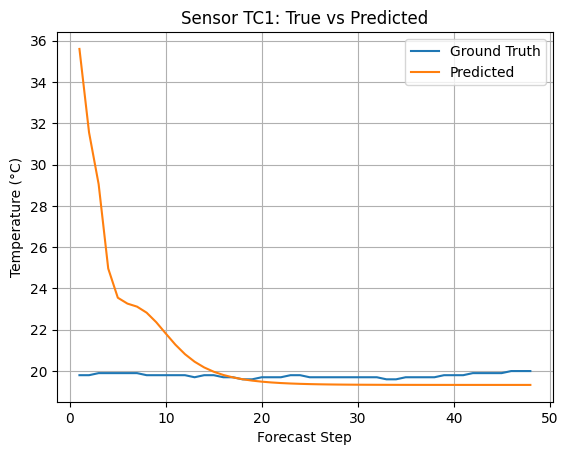

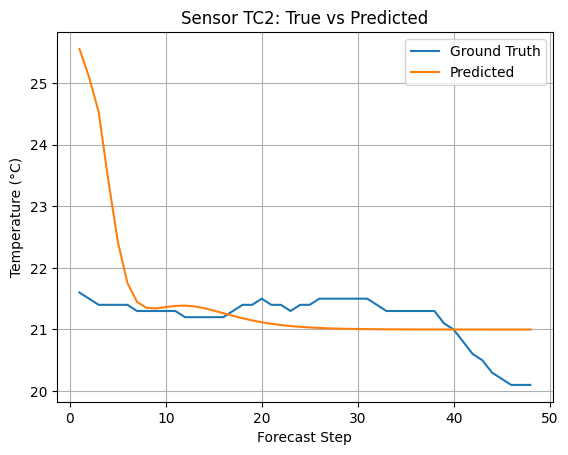

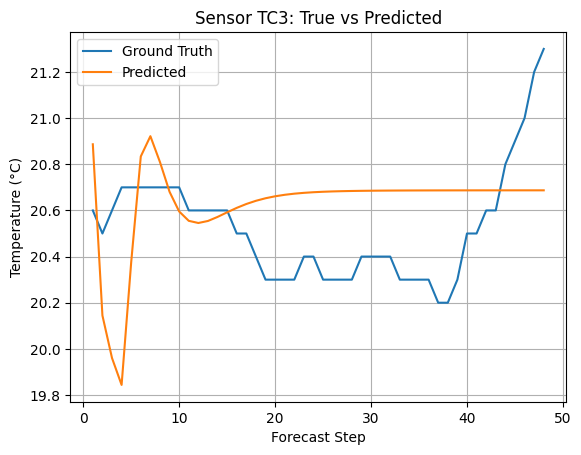

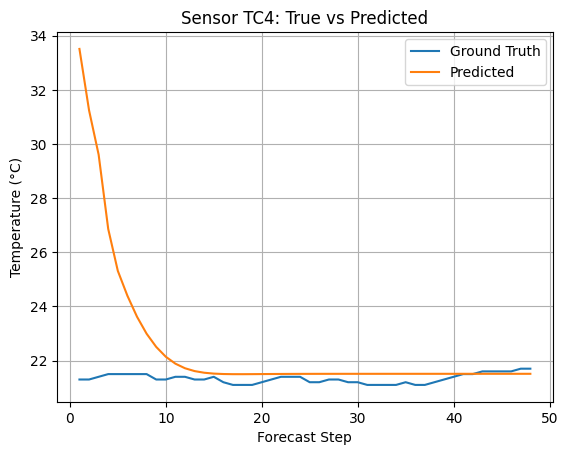

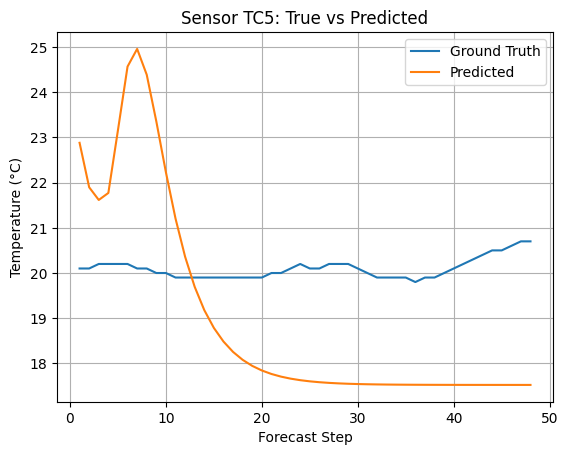

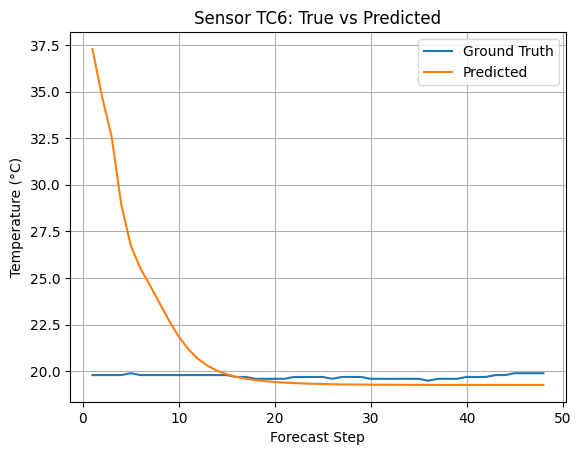

In [32]:

for i in range(num_sensors):
    plt.figure()
    plt.plot(steps, y_true_flat[:, i], label='Ground Truth')
    plt.plot(steps, y_pred_flat[:, i], label='Predicted')
    plt.title(f'Sensor TC{i+1}: True vs Predicted')
    plt.xlabel('Forecast Step')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)


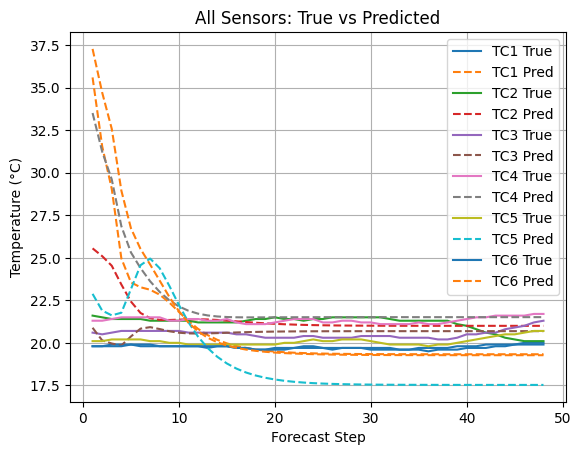

In [33]:

plt.figure()
for i in range(num_sensors):
    plt.plot(steps, y_true_flat[:, i], label=f'TC{i+1} True')
    plt.plot(steps, y_pred_flat[:, i], '--', label=f'TC{i+1} Pred')
plt.title('All Sensors: True vs Predicted')
plt.xlabel('Forecast Step')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)


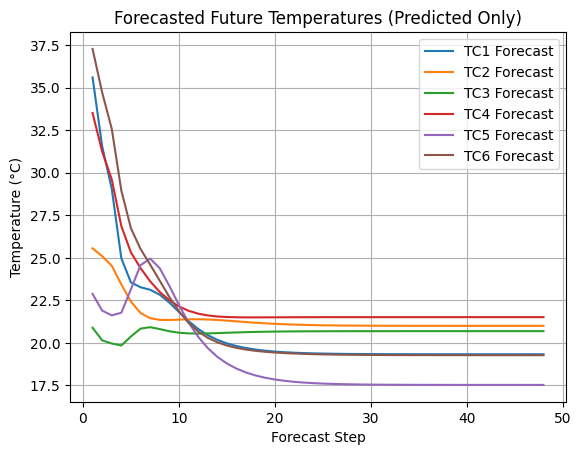

In [34]:

plt.figure()
for i in range(num_sensors):
    plt.plot(steps, y_pred_flat[:, i], label=f'TC{i+1} Forecast')
plt.title('Forecasted Future Temperatures (Predicted Only)')
plt.xlabel('Forecast Step')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)


In [35]:
sensor_maes = []
sensor_rmses = []
print("=== Sensor-wise Performance Metrics ===")
for i in range(num_sensors):
    mae = mean_absolute_error(y_true_flat[:, i], y_pred_flat[:, i])
    rmse = np.sqrt(mean_squared_error(y_true_flat[:, i], y_pred_flat[:, i]))
    sensor_maes.append(mae)
    sensor_rmses.append(rmse)
    print(f'Sensor TC{i+1}: MAE = {mae:.4f}, RMSE = {rmse:.4f}')


=== Sensor-wise Performance Metrics ===
Sensor TC1: MAE = 1.5779, RMSE = 3.4218
Sensor TC2: MAE = 0.5875, RMSE = 1.0282
Sensor TC3: MAE = 0.2837, RMSE = 0.3335
Sensor TC4: MAE = 1.2023, RMSE = 2.8101
Sensor TC5: MAE = 2.3959, RMSE = 2.5493
Sensor TC6: MAE = 1.9808, RMSE = 4.3616


In [36]:

avg_mae = np.mean(sensor_maes)
avg_rmse = np.mean(sensor_rmses)
print("=== Overall Average Metrics ===")
print(f'Average MAE: {avg_mae:.4f}')
print(f'Average RMSE: {avg_rmse:.4f}')

plt.show()

=== Overall Average Metrics ===
Average MAE: 1.3380
Average RMSE: 2.4174


In [37]:
threshold = 80.0
exceeds   = (Y_pred >= threshold)
mask_any  = np.any(exceeds, axis=1)

In [38]:
if mask_any.any():
    t_idx      = np.argmax(mask_any)
    print(f"\nALERT: Thermal runaway predicted at forecast step {t_idx+1}")


    breach_row = last_obs_idx + (t_idx + 1)
    t_last     = df.loc[last_obs_idx, 'Test Time [s]']
    t_breach   = df.loc[breach_row,   'Test Time [s]']
    lead_time  = t_breach - t_last

    print(f"Lead time to runaway: {lead_time:.1f} seconds")

else:
    print("\n No thermal runaway predicted within the 48-step horizon")



 No thermal runaway predicted within the 48-step horizon
